In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import Bounds
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

In [2]:
def set_ticks(ax, xMaj, xMin, yMaj, yMin):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.xaxis.set_minor_locator(AutoMinorLocator(xMin))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.yaxis.set_minor_locator(AutoMinorLocator(yMin))
    ax.tick_params(which='major', width=1.0, length=10, direction="in", labelsize=12)
    ax.tick_params(which='minor', width=1.0, length=5, direction="in", labelsize=12)

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

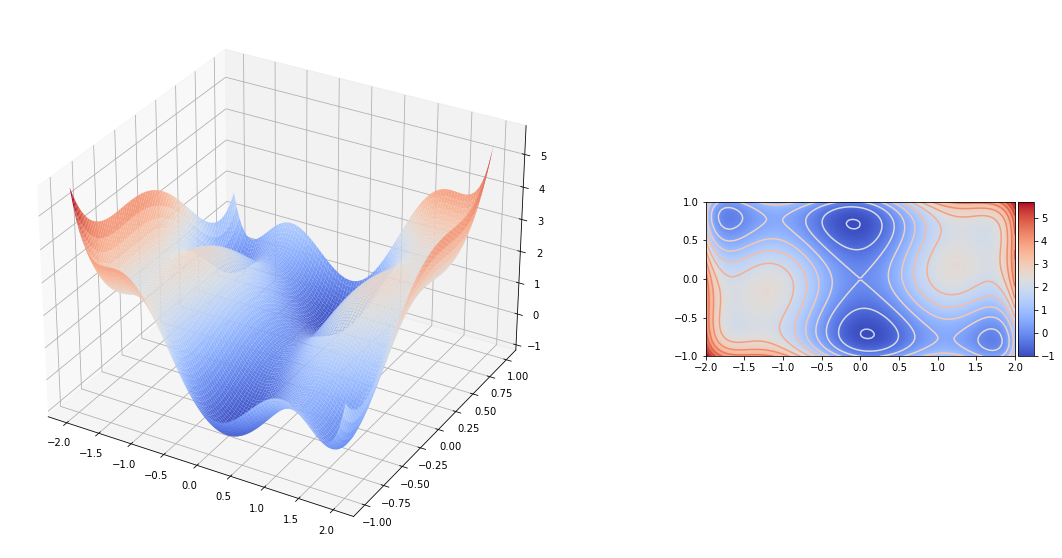

In [3]:
# function
def f(parameters):
    x, y = parameters
    return (4 - 2.1*x**2 + x**4/3.) * x**2 + x * y + (4*y**2 - 4) * y**2

# domain
xs = np.linspace(-2, 2, 100)
ys = np.linspace(-1, 1, 100)
x, y = np.meshgrid(xs, ys)

# plot layout
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((1, 3), (0, 0), rowspan=1, colspan=2, projection='3d')
ax2 = plt.subplot2grid((1, 3), (0, 2), rowspan=1, colspan=1)

# 3d plot
ax1.plot_surface(x, y, f((x,y)), cstride=1, rstride=1, cmap='coolwarm')

# heat map and contour plot
im = ax2.imshow(f((x,y)), cmap='coolwarm', origin='lower', extent=[-2, 2, -1, 1])
ax2.contour(x, y, f((x,y)), cmap='coolwarm', levels=np.arange(-6, 6, 0.5))

# add colorbar
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax2, orientation='vertical')

# show
plt.show()

In [4]:
'''
    Once the minimum points have been identified
    thanks to the previous plots, I define bounds to
    search for the points using scipy.optimize.minimize().
'''

# specify bounds: splits [-1,1] in half and [-2,2] in three parts
bounds = [Bounds([-2, -1], [-1, 0]), Bounds([-1, -1], [1, 0]), Bounds([1, -1], [2, 0]), 
          Bounds([-2,  0], [-1, 1]), Bounds([-1,  0], [1, 1]), Bounds([1,  0], [2, 1])]

# initial starting point [x0, y0]
p0 = [[-1.5, -0.5], [0., -0.5], [1.5, -0.5],
      [-1.5,  0.5], [0.,  0.5], [1.5,  0.5]]

print("Minimizing the function...")

# unzip the bounds
for guess, bound in zip(p0, bounds):

    # apply algorithm 
    res = sp.optimize.minimize(f, guess, bounds=bound)
    resPar = res.x
    x_min, y_min = resPar
    print("\nx_min =", x_min,"\ty_min =", y_min,
          "\tf(x_min, y_min) =", f(resPar))

Minimizing the function...

x_min = -1.6071049259309291 	y_min = -0.5686518877757405 	f(x_min, y_min) = 2.1042503103121803

x_min = 0.08984198346231073 	y_min = -0.7126564006047424 	f(x_min, y_min) = -1.031628453489874

x_min = 1.703607010539061 	y_min = -0.796083820093631 	f(x_min, y_min) = -0.21546382438224965

x_min = -1.7036069919488375 	y_min = 0.7960838106157976 	f(x_min, y_min) = -0.2154638243823992

x_min = -0.0898419923336939 	y_min = 0.7126563923169865 	f(x_min, y_min) = -1.031628453489875

x_min = 1.6071049470809051 	y_min = 0.5686518804518959 	f(x_min, y_min) = 2.1042503103122043


In [5]:
'''
    Try to find the minimum with an initial
    guess of (0, 0). This is a saddle point 
    of the function. As a result, the algorithm
    'does not move' from it when trying to 
    minimize the function.
'''

print("Minimizing the function, using (0, 0) as the starting point...")
p0 = [0., 0.]
res = sp.optimize.minimize(f, p0)
resPar = res.x
x_min, y_min = resPar
print("\nx_min =", x_min,"\ty_min =", y_min, 
      "\tf(x_min, y_min) =", f(resPar))

Minimizing the function, using (0, 0) as the starting point...

x_min = 0.0 	y_min = 0.0 	f(x_min, y_min) = 0.0


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

The covariance matrix for the Max. Temp. interpolation is:
 [[ 0.16816513 -0.00085903  0.00522871  0.00654946]
 [-0.00085903  0.00044873 -0.00296277  0.00640303]
 [ 0.00522871 -0.00296277  0.02135893 -0.04204045]
 [ 0.00654946  0.00640303 -0.04204045  0.18340296]] 
and the fit results are:
a = 10.582 +- 0.410
b = 0.592 +- 0.021
c = 3.872 +- 0.146
d = 27.950 +- 0.428

The R2 of the Max. Temp. interpolation is: 0.9882502430477913

The covariance matrix for the Min. Temp. interpolation is:
 [[ 1.72807308e+00 -2.48176977e-04 -3.66452355e-03  1.89188369e-01]
 [-2.48176977e-04  5.30715542e-04 -3.55963771e-03  1.60003531e-02]
 [-3.66452355e-03 -3.55963771e-03  2.70520449e-02 -1.04189097e-01]
 [ 1.89188369e-01  1.60003531e-02 -1.04189097e-01  1.41860196e+00]] 
and the fit results are:
a = 25.150 +- 1.315
b = 0.601 +- 0.023
c = 3.565 +- 0.164
d = -36.713 +- 1.191

The R2 of the Min. Temp. interpolation is: 0.9787202745547442

The time offset of the temperature distributions is 0.410220334408908

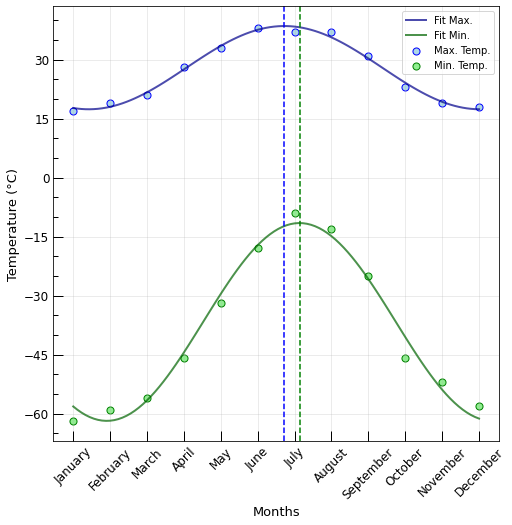

In [6]:
'''
    Show the data. I assume that the temperatures in
    Alaska oscillate periodically, hence I interpolate
    with a sin-like function.
'''
# data
maxT = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
minT = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
x = np.arange(1, 13, 1)
months = np.array(['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December'])

# sin-like function
def f(x, a, b, c, d ):
    return a * np.sin(b * x + c) + d

# interpolation
guessMax = np.array([10., 0.5, 3., 30.]) # needed in order to make the fit converge
fMax, covMax = sp.optimize.curve_fit(f, x, maxT, guessMax)
#print(fMax)
guessMin = np.array([20., 0.5, 3., -30.]) # needed in order to make the fit converge
fMin, covMin = sp.optimize.curve_fit(f, x, minT, guessMin)
#print(fMin)

# manually find the maximum of the functions by deriving f
xMax = (5*np.pi/2 - fMax[2]) / fMax[1]
xMin = (5*np.pi/2 - fMin[2]) / fMin[1]

# plot layout
fig, ax = plt.subplots(figsize=(8, 8))
ax.grid(linestyle='-', alpha=0.3)
set_ticks(ax, 1, 1, 15, 3)

# plot data
ax.scatter(x, maxT, marker='o', color='lightblue', edgecolor='blue', s=50, label='Max. Temp.')
ax.scatter(x, minT, marker='o', color='lightgreen', edgecolor='green', s=50, label='Min. Temp.')

# plot interpolation
domain = np.linspace(1, 12, 100)
ax.plot(domain, f(domain, *fMax), linewidth='2', color='darkblue', alpha=0.7, label='Fit Max.')
ax.plot(domain, f(domain, *fMin), linewidth='2', color='darkgreen', alpha=0.7, label='Fit Min.')

# plot maximum values of functions
ax.axvline(xMax, color='blue',linestyle='dashed')
ax.axvline(xMin, color='green',linestyle='dashed')

# labels
_ = plt.xticks(x, months, rotation=45)
ax.set_xlabel("Months", fontsize=13)
ax.set_ylabel("Temperature (°C)", fontsize=13)
_ = ax.legend(loc="best", markerscale=1)

'''
    Comments on the interpolations. The fit errors are
    small with respect to the resulting values for each parameter.
    In addition to this, the value of the R2 is near 1, i.e. the 
    function describe the data fairly well.
    Note that since this is not a linear regression, R2 and R 
    are different values.
'''

params = ['a', 'b', 'c', 'd']

# fit results - max temperatures
print("The covariance matrix for the Max. Temp. interpolation is:\n", covMax,
      "\nand the fit results are:")
for p, i, si in zip(params, fMax, np.diagonal(covMax)):
    print("%c = %1.3f +- %1.3f" % (p, i, np.sqrt(si)))

ssrMax = np.sum((f(x, *fMax) - maxT)**2)
tssMax = np.sum((np.mean(maxT) - maxT)**2)
rsqMax = 1. - ssrMax / tssMax
print("\nThe R2 of the Max. Temp. interpolation is:", rsqMax)
#print("R:", np.sqrt(rsqMax))

# fit results - min temperatures
print("\nThe covariance matrix for the Min. Temp. interpolation is:\n", covMin,
      "\nand the fit results are:")
for p, i, si in zip(params, fMin, np.diagonal(covMin)):
    print("%c = %1.3f +- %1.3f" % (p, i, np.sqrt(si)))
    
ssrMin = np.sum((f(x, *fMin) - minT)**2)
tssMin = np.sum((np.mean(minT) - minT)**2)
rsqMin = 1. - ssrMin / tssMin
print("\nThe R2 of the Min. Temp. interpolation is:", rsqMin)
#print("R:", np.sqrt(rsqMin))

print("\nThe time offset of the temperature distributions is", np.abs(xMax - xMin),
      "which roughly corresponds to half a month. The two 'center values' are fairly close, given the fit accuracy.")

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [8]:
# get data
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

The covariance matrix for the interpolation is:
 [[ 1.38291713e+03 -3.82370427e-04 -1.16192675e-01  5.58118430e+00
  -8.77057070e+01]
 [-3.82370427e-04  2.11283909e-05 -1.17591233e-07 -4.57217107e-03
   1.44100370e-04]
 [-1.16192675e-01 -1.17591233e-07  4.75279271e-05  1.71640395e-03
  -2.69720844e-02]
 [ 5.58118430e+00 -4.57217107e-03  1.71640395e-03  6.67369259e+01
  -2.10333669e+00]
 [-8.77057070e+01  1.44100370e-04 -2.69720844e-02 -2.10333669e+00
   1.23852104e+02]] 
and the fit results are:
a = 2048.936 +- 37.188
mu = -0.087 +- 0.005
b = 0.315 +- 0.007
m = -13.107 +- 8.169
q = 63.036 +- 11.129

The R2 of the Max. Temp. interpolation is: 0.9882502430477913

The Chi2 is: 460.87864742661935 
The p-value is: 3.0103342033506336e-79


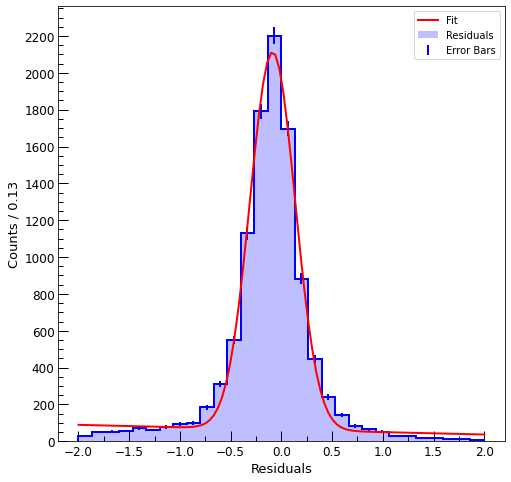

In [9]:
fName = "data/residuals_261.pkl"

# get data with pandas
df = pd.DataFrame(np.load(fName, allow_pickle=True).item())

# clean data
data = df[np.abs(df['residuals']) < 2]

# plot layout
fig, ax = plt.subplots(figsize=(8, 8))
set_ticks(ax, 0.5, 2, 200, 4)

# histogram
y, binEdges, _ = ax.hist(data.loc[:,'residuals'], bins=30, histtype="stepfilled", label="Residuals", facecolor="blue", alpha=0.25)
_ = ax.hist(data.loc[:,'residuals'], bins=30, histtype="step", edgecolor="blue", linewidth=2)

# histogram layout
binCenters = 0.5 * (binEdges[1:] + binEdges[:-1])
binWidth = binEdges[1] - binEdges[0]
binErrors = np.sqrt(y)

# plot errorbars
ax.errorbar(binCenters, y, binErrors, fmt = 'none', label = "Error Bars", ecolor="blue", linewidth=2)

'''
    Fit. By looking at the distribution, it seems to be
    Gaussian with a linear background, since the 'right shoulder'
    is lower than the left one.
'''

def f(x, a, mu, b, m, q):
    return a * np.exp(-(x - mu)**2 / b**2) + m * x + q
    
# interpolation
guess = np.array([1500., 0., 1., 1., 5.]) # needed in order to make the fit converge
params, cov = sp.optimize.curve_fit(f, binCenters, y, guess)

domain = np.linspace(-2, 2, 100)
ax.plot(domain, f(domain, *params), color='red', linewidth=2, label='Fit')

# labels
ax.set_xlabel("Residuals", fontsize=13)
ax.set_ylabel("Counts / %1.2f" % binWidth, fontsize=13)
_ = ax.legend(loc='upper right', markerscale=1)

'''
    Goodness of fit. The R2 parameter is near 1, i.e. the function
    describe the data fairly well. Nevertheless, at least visually,
    the 'background' does not seem very linear. I tried with other
    models and this is still the best result.
'''

names = ['a', 'mu', 'b', 'm', 'q']

# covariance and r2
print("The covariance matrix for the interpolation is:\n", cov,
      "\nand the fit results are:")
for p, i, si in zip(names, params, np.diagonal(cov)):
    print("%s = %1.3f +- %1.3f" % (p, i, np.sqrt(si)))

ssr = np.sum((f(binCenters, *params) - y)**2)
tss = np.sum((np.mean(y) - y)**2)
rsq = 1. - ssrMax / tssMax
print("\nThe R2 of the Max. Temp. interpolation is:", rsq)

# chi-squared test and p-value
chi2, p = stats.chisquare(y, f(binCenters, *params))
print("\nThe Chi2 is:", chi2,
      "\nThe p-value is:", p)

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [11]:
# get data
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -P data/

The covariance matrix for the interpolation with f(x) is:
 [[ 1.75558202e-02  9.85997337e-07 -2.76510550e-06]
 [ 9.85997337e-07  1.77326375e-04  5.40543800e-08]
 [-2.76510550e-06  5.40543800e-08  8.78853325e-03]] 
and the fit results are:
a = -9.962 +- 0.132
b = 12.332 +- 0.013
c = 9.263 +- 0.094

The b = 12.332 +- 0.013 parameter is the phase of the sinusoidal function and it tells that the temperature trend repeats every b months.

Analysis of the temperatures...
The overall average temperature in Munich between 2008 and 2012 is: 9.261252084167236 °C
The predicted average temperature is: 9.262821312719248 °C

The predicted daily temperature in the hottest time of the year is: 19.22485599096096 °C
and the average daily temperature around that time is: 18.344749315068494

The predicted daily temperature in the coldest time of the year is: -0.6992133655224659 °C
and the average daily temperature around that time is: -1.6869384108108103


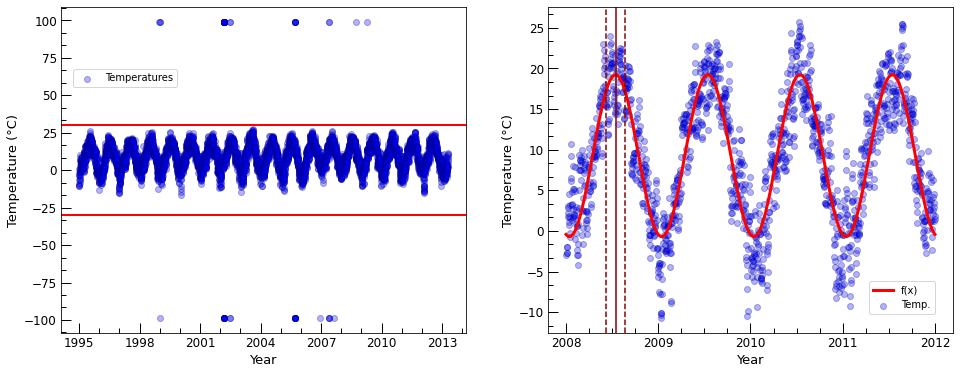

In [12]:
'''
    Show data. Each datum refers to a day; data are
    displayed in units of years.
'''
# read file
data = pd.read_csv("data/munich_temperatures_average_with_bad_data.txt", names=('Date', 'Temperature'), delimiter=' ')

# plot layout
fig, (ax1, ax2) = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
set_ticks(ax1, 3, 3, 25, 3)
set_ticks(ax2, 1, 4, 5, 3)

# plot
ax1.scatter(data['Date'], data['Temperature'], marker='o', color='blue',
            edgecolor='darkblue', alpha=0.3, label='Temperatures' )

# plot maximum values of functions
ax1.axhline(30., color='red',linestyle='-', linewidth='2')
ax1.axhline(-30., color='red',linestyle='-', linewidth='2')

# labels
ax1.set_xlabel("Year", fontsize=13)
ax1.set_ylabel("Temperature (°C)", fontsize=13)
_ = ax1.legend(bbox_to_anchor=(0.3,0.825), markerscale=1)

'''
    Clean data by discarding outliers (non-physical values).
    Fit with f(x).
'''
# clean the data
cleanData = data[(np.abs(data['Temperature']) < 30) & (data['Date'] > 2008) & (data['Date'] < 2012)]

# interpolation
def f(x, a, b, c):
    return a * np.cos(2 * np.pi * x + b) + c

# plot
ax2.scatter(cleanData['Date'], cleanData['Temperature'], marker='o', color='blue',
           edgecolor='darkblue', alpha=0.3, label='Temp.' )

# interpolation
params, cov = sp.optimize.curve_fit(f, cleanData['Date'], cleanData['Temperature'])

# plot interpolation
domain = np.linspace(2008, 2012, 1000)
ax2.plot(domain, f(domain, *params), color='red', linewidth=3, label='f(x)')

# labels
ax2.set_xlabel("Year", fontsize=13)
ax2.set_ylabel("Temperature (°C)", fontsize=13)
_ = ax2.legend(bbox_to_anchor=(0.78,0.175), markerscale=1)

# fit results
names = ['a', 'b', 'c']
print("The covariance matrix for the interpolation with f(x) is:\n", cov,
      "\nand the fit results are:")
for p, i, si in zip(names, params, np.diagonal(cov)):
    print("%c = %1.3f +- %1.3f" % (p, i, np.sqrt(si)))
    
# physical meaning of b
print("\nThe b = %1.3f +- %1.3f parameter is the phase of the sinusoidal function" % (params[1], np.sqrt(cov[1,1])),
      "and it tells that the temperature trend repeats every b months.")
    
'''
    Temperature analysis. The coldest (hottest) times of the 
    year correspond to the minimum (maximum) points of the 
    fitted function. Note that the function is differentiable
    and thus the stationary points can be found analitically.
    Sice the function period is 1, all the other maximum points
    are xMax + k * 1 and the minimum points are xMax + k * 0.5, with 
    k = 1, 2, 3, ... .
'''

print("\nAnalysis of the temperatures...")

# overall average temperature
print("The overall average temperature in Munich between 2008 and 2012 is:", 
      np.mean(cleanData['Temperature']), "°C")
print("The predicted average temperature is:", params[2], "°C")

# peaks position
xMax = (4021*np.pi - params[1]) / (2 * np.pi) # first maximum
xMin = xMax + 0.5 # first minimum

# roughly choose a three months range (a season) around the peak 
ax2.axvline(xMax, color='darkred',linestyle='-')
ax2.axvline(xMax - 0.1, color='darkred',linestyle='--')
ax2.axvline(xMax + 0.1, color='darkred',linestyle='--')

# print temperatures
maxT = np.mean(data[(data['Date'] > xMax - 0.1) & (data['Date'] < xMax + 0.1)]['Temperature'])
print("\nThe predicted daily temperature in the hottest time of the year is:", f(xMax, *params),
      "°C\nand the average daily temperature around that time is:", maxT)

minT = np.mean(data[(data['Date'] > xMin - 0.1) & (data['Date'] < xMin + 0.1)]['Temperature'])
print("\nThe predicted daily temperature in the coldest time of the year is:", f(xMin, *params),
      "°C\nand the average daily temperature around that time is:", minT)

The covariance matrix for the interpolation with f(x) is:
 [[ 1.75558202e-02  9.85997337e-07 -2.76510550e-06]
 [ 9.85997337e-07  1.77326375e-04  5.40543800e-08]
 [-2.76510550e-06  5.40543800e-08  8.78853325e-03]] 
and the fit results are:
a = -9.961 +- 0.133
b = 1.000 +- 0.002
c = 8.624 +- 23.792
d = 9.266 +- 0.096


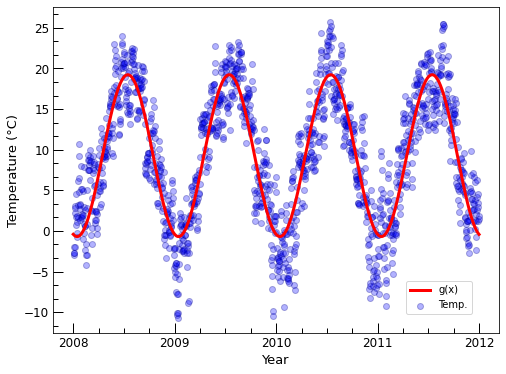

In [13]:
'''
    Fit with an additional parameter.
'''

# function
def g(x, a, b, c, d):
    return a * np.cos(2 * np.pi * b * x + c) + d

# plot layout
fig, ax = plt.subplots(figsize=(8, 6))
set_ticks(ax, 1, 4, 5, 3)

# plot
ax.scatter(cleanData['Date'], cleanData['Temperature'], marker='o', color='blue',
           edgecolor='darkblue', alpha=0.3, label='Temp.' )

# interpolation
params_g, cov_g = sp.optimize.curve_fit(g, cleanData['Date'], cleanData['Temperature'])

# plot interpolation
domain = np.linspace(2008, 2012, 1000)
ax.plot(domain, g(domain, *params_g), color='red', linewidth=3, label='g(x)')

# labels
ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Temperature (°C)", fontsize=13)
_ = ax.legend(bbox_to_anchor=(0.78,0.175), markerscale=1)

# fit results
names = ['a', 'b', 'c', 'd']
print("The covariance matrix for the interpolation with f(x) is:\n", cov,
      "\nand the fit results are:")
for p, i, si in zip(names, params_g, np.diagonal(cov_g)):
    print("%c = %1.3f +- %1.3f" % (p, i, np.sqrt(si)))

In [14]:
'''
    Compute the RSS for the two interpolating functions.
'''

x = cleanData['Date']
y = cleanData['Temperature']
rss_f = np.sum((y - f(x, *params))**2)
rss_g = np.sum((y - g(x, *params_g))**2)
print("RSS_f = %.3f\nRSS_g = %.3f" % (rss_f, rss_g))

'''
    Fisher test. If the Confidence Level is below 0.10
    then the additional parameter is necessary.
'''

# number of degrees of freedom for the interpolations
dof1 = 3 - 1
dof2 = 4 - 1

# compute confidence level
n = len(x)
F = ((rss_f - rss_g) / (dof2 - dof1)) / (rss_g / (n - dof2))
CL = 1. - stats.f.cdf(F, dof2 - dof1, n - dof2)

# check if the parameter is needed and print
check = CL < 0.10
print("Confidence Level =", CL,
      "\nIs an additional parameter needed?", check)

RSS_f = 18669.515
RSS_g = 18669.225
Confidence Level = 0.8804857908387174 
Is an additional parameter needed? False
